# Exercise 2: Bloom filter

In [1]:
# Implement a Bloom filter using bitarray
import bitarray as bit
from hashlib import sha3_256, sha256, blake2b

class BloomFilter:
    def __init__(self, size, hashes):
        self.size = size # Specify filter size
        self.hashes = hashes # Specify desired hash functions
        self.bitarray = bit.bitarray(size) # Initialize bitarray with defined size
        self.bitarray.setall(0) # Set all values in the bitarray to zero

    # Define generic hash function, which returns the bitarray index
    def get_hash(self, value, hash):
        return int(hash(value.lower().encode()).hexdigest(), 16) % self.size
    
    # Add a value to the Bloom filter
    def add(self, value):
        for hash in self.hashes: # Apply value through selected hash functions
            index = self.get_hash(value, hash) # Get hashed value to bitarray index
            self.bitarray[index] = 1 # Set corresponding position in bitarray to 1 (occupied)

    # Check if a value is in the Bloom filter (may return false positives)
    def lookup(self, value):
        for hash in self.hashes:
            index = self.get_hash(value, hash)
            if self.bitarray[index] == 0: # If index position in bitarray is empty, the word is not there
                return False
        return True

In [2]:
# Test the Bloom filter
hi = BloomFilter(size = 100, hashes = [sha256])
hi.add("Hello!")
print(hi.lookup("Hello!"))   # True
print(hi.lookup("Goodbye!")) # False

bruh = BloomFilter(size = 10_000, hashes = [sha256, blake2b, sha3_256])
print(bruh.lookup("bruh")) # False
bruh.add("bruh")
print(bruh.lookup("bruh")) # True

True
False
False
True


In [3]:
# Store words.txt (~500,000 words, assuming correct spelling) into a Bloom filter
# Note: To avoid hash collisions, the absolute minimum for a corpus of 500,000 words with 3 hash functions is 150,000 bits.
# For a starting point, at least 1,000,000 bits is recommended; 10,000,000 bits to be safe.
corpus = BloomFilter(size = 100_000_000, hashes = [sha256, blake2b, sha3_256])

with open("words.txt") as file:
    for line in file:
        word = line.strip()
        corpus.add(word)

# Test the primed Bloom filter
print(corpus.lookup("cb&b634"))       # False
print(corpus.lookup("computational")) # True
print(corpus.lookup("methods"))       # True
print(corpus.lookup("for"))           # True
print(corpus.lookup("informatics"))   # True
print(corpus.lookup("robert"))        # True
print(corpus.lookup("mcdougal"))      # True (huh?)

False
True
True
True
True
True
True


In [4]:
# Create a spell checker using the Bloom filter class
# Note: May return more false positives (e.g. suggesting a word not in the list) with smaller filters and fewer hash functions.
def spell_checker(word, BloomFilter):
    # If the word is in the specified Bloom filter, it may be correctly spelled
    if BloomFilter.lookup(word):
        return(f"'{word}' may be spelled correctly.")
    
    # If not, generate all possible single-letter substitutions and test them against Bloom filter
    word_suggestions = []
    for char in range(len(word)):
        for letter in "abcdefghijklmnopqrstuvwxyz":
            candidate = word[:char] + letter + word[char+1:] # Slice word to test every letter at every character position
            if BloomFilter.lookup(candidate): # Suggest candidate if it is in the Bloom filter
                word_suggestions.append(candidate)

    # Return candidate words
    return word_suggestions

print(spell_checker("bruh", corpus))   # ['pruh', 'bluh', 'brum', 'brut'] (non-deterministic for some reason? shouldn't a hash be deterministic?)
print(spell_checker("moment", corpus)) # 'moment' may be spelled correctly.

['pruh', 'bluh', 'brum', 'brut']
'moment' may be spelled correctly.


In [13]:
# Test spell checker on typos.json
import json

def accuracy_checker(BloomFilter):
    # Load list of typos
    with open("typos.json") as file:
        typos = json.load(file) # Creates list of [typed_word, correct_word] pairs

    # Check if correct word is produced by the specified Bloom filter and that it gives no more than 3 suggestions
    correct_count = 0
    for typo in typos:
        suggestions = spell_checker(typo[0], BloomFilter)
        if (typo[1] in suggestions) and (len(suggestions) <= 3):
            correct_count += 1

    # Return spell checker accuracy
    return correct_count

In [15]:
# Test spell checker accuracy
corpus = BloomFilter(size = 100_000_000, hashes = [sha256, blake2b, sha3_256])
with open("words.txt") as file:
    for line in file:
        word = line.strip()
        corpus.add(word)

print("Number of good suggestions:", accuracy_checker(corpus))

Number of good suggestions: 23702


In [30]:
# Test accuracy against filter size
from tqdm import tqdm

#sizes = list(np.linspace(start = 10_000, stop = 100_000_000, num = 10, dtype = int)) # Generate evenly spaced Bloom filter sizes
sizes = [10_000, 50_000, 100_000, 500_000, 1_000_000, 5_000_000, 10_000_000, 50_000_000, 100_000_000, 500_000_000, 1_000_000_000]
hash_sets = [[sha256], [sha256, blake2b], [sha256, blake2b, sha3_256]]

results = []
for size in tqdm(sizes):
    for hash_set in hash_sets:
        filter = BloomFilter(size, hash_set)
        with open("words.txt") as file:
            for line in file:
                word = line.strip()
                filter.add(word)
        good_suggestions = accuracy_checker(filter)
        results.append((size, len(hash_set), good_suggestions))

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [11:35<00:00, 63.19s/it]


[None,
 Text(0.5, 1.0, 'Bloom Filter Size against Number of Good Word Suggestions'),
 Text(0.5, 0, 'Size'),
 Text(0, 0.5, 'Good Word Suggestions')]

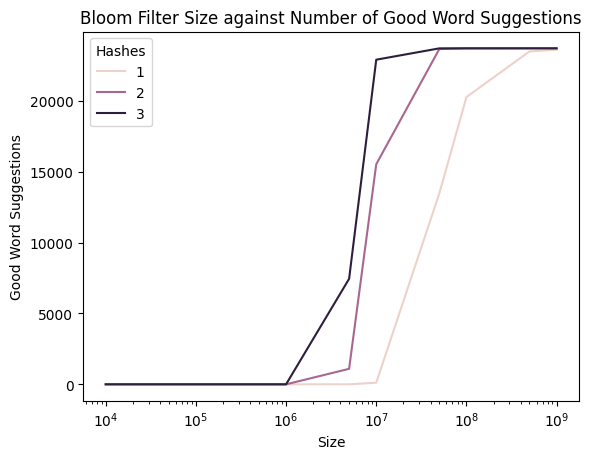

In [36]:
# Plot filter size against hash function choice (first, first two, all three)
import seaborn as sns
import pandas as pd
import warnings

warnings.filterwarnings('ignore') # Suppress seaborn's warnings

df = pd.DataFrame(results, columns=["Size", "Hashes", "Good_Suggestions"])
plot = sns.lineplot(data=df, x="Size", y="Good_Suggestions", hue="Hashes")
plot.set(xscale = "log", title = "Bloom Filter Size against Number of Good Word Suggestions",
         xlabel = "Size", ylabel = "Good Word Suggestions")

**Discussion:** On a semi-log plot, the number of good suggestions for all three filters starts out close to zero, then increases rapidly and then levels off. However, none of the hash choices manages to break ~50% accuracy, and past a filter size of $10^8$ bits, there appear to be diminishing returns. I suspect that there is an error in my Bloom filter implementation that I am unable to spot. Therefore, my educated guess as to the number of necessary bits to achieve 90% accuracy is at least $10^8$ bits for the given corpus and list of typos.